## ROMS grid

* ROMS variables are staggered according to the Arakawa C-grid 
* It uses a north-east index convention
* center points are labelled (xh, yh) and corner points are labelled (xq, yq)
* important: variables xh/yh, xq/yq that are named "nominal" longitude/latitude **are not** the true geographical coordinates and are not suitable for plotting (more later)



<div>
<img src="images/cgrid.png" width="350">
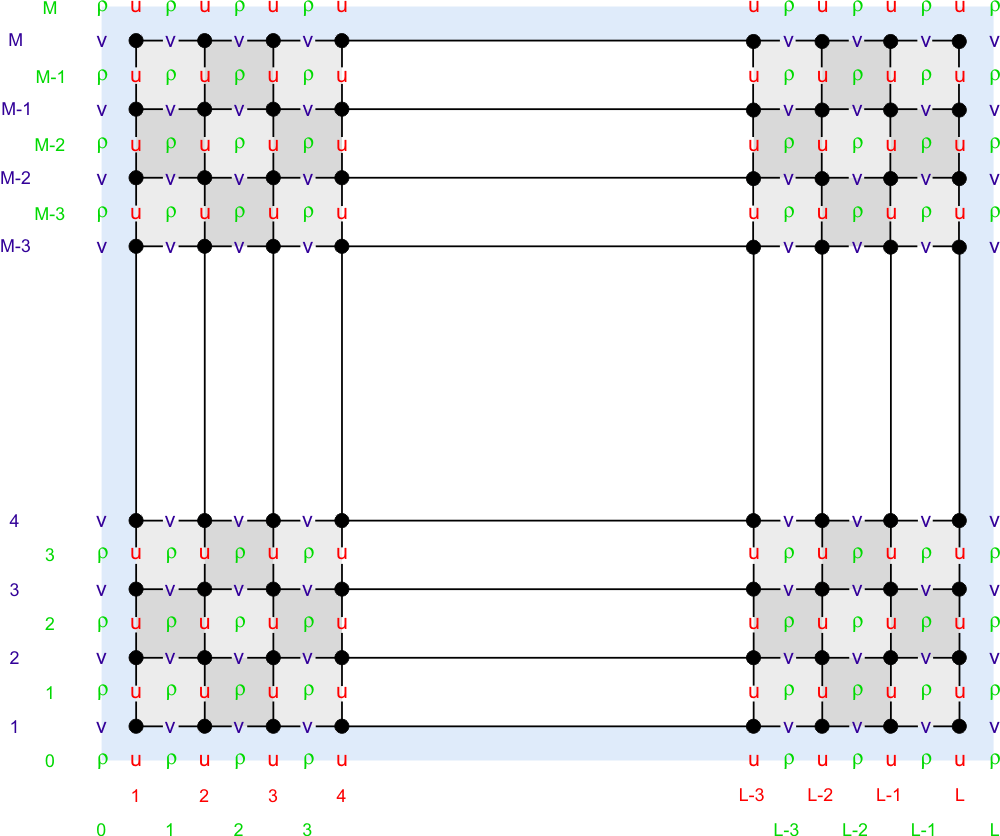
<p>source:<a href="https://www.myroms.org/wiki/Numerical_Solution_Technique">myroms.org</a>
    ,<a href="https://doi.org/10.1016/j.jcp.2011.11.025">Rajpoot et al. (2012)</a></p>
</div>


In [24]:
import xarray as xr
import xgcm
import numpy as np
import matplotlib.pyplot as plt

file = '/scratch/training/python_geos/data/ROMS/roms_test.nc'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 2, s_w: 51, eta_rho: 489, xi_rho: 655, tracer: 2, s_rho: 50, boundary: 4, eta_psi: 488, xi_psi: 654, eta_u: 489, xi_u: 654, eta_v: 488, xi_v: 655)
Coordinates:
    lat_psi      (eta_psi, xi_psi) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
    lon_psi      (eta_psi, xi_psi) float64 ...
    lon_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
  * ocean_time   (ocean_time) datetime64[ns] 2010-01-05T03:00:00 2010-01-05T0...
  * s_rho        (s_rho) float64 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
  * s_w          (s_w) float64 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
Dimensions without coordinates: eta_rho, xi_rho, tracer, boundary, eta_psi, xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/74)
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKv          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    Akt_bak      (tracer) float64 ...
    Akv_bak      float64 ...
    Cs_r         (s_rho) float64 ...
    Cs_w         (s_w) float64 ...
    ...           ...
    ubar         (ocean_time, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    vbar         (ocean_time, eta_v, xi_v) float32 ...
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    xl           float64 ...
    zeta         (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/26)
    file:              GOM_hurr_wrf_19950930-06.ocn_0002.hi.1995-10-04_09:00:...
    format:            netCDF-3 classic file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             BP_2010 Coupled Hindcast Run
    rst_file:          gom03_rst.nc
    ...                ...
    compiler_flags:    -fp-model precise -ip -O2 -debug minimal -free -free
    tiling:            020x018
    history:           Thu Nov  4 09:41:12 2021: ncks -d ocean_time,0,1 roms_...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_hm...
    CPP_options:       TXGLO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAP...
    NCO:               netCDF Operators version 4.9.7 (Homepage = http://nco....

### Creating the grid object

Next we create a `Grid` object from the dataset.
We need to tell xgcm that the `X` and `Y` axes are periodic.
(The other axes will be assumed to be non-periodic.)

In [81]:
ds = ds.rename({'eta_u': 'eta_rho','xi_v': 'xi_rho'})

coords = {
        "X": {"center": "xi_rho", "inner": "xi_u"},
        "Y": {"center": "eta_rho", "inner": "eta_v"},
        "Z": {"center": "s_rho", "outer": "s_w"},
    }

grid = xgcm.Grid(ds, coords=coords, periodic=[])

In [64]:
grid
ds.pn

<xarray.DataArray 'pn' (eta_rho: 489, xi_rho: 655)>
[320295 values with dtype=float64]
Coordinates:
    lon_rho  (eta_rho, xi_rho) float64 ...
    lat_rho  (eta_rho, xi_rho) float64 ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  curvilinear coordinate metric in ETA
    units:      meter-1
    field:      pn, scalar

We see that xgcm identified five different axes: X (longitude), Y (latitude), Z (depth),  T (time), and 1RHO (the axis generated by the output of the LAYERS package).

## Horizontal Interpolation

### Flow velocity

$$ \large Speed = \sqrt{U_{rho}^2 + V_{rho}^2} \ . $$

Below we use xgcm to compute the velocity gradients of the horizontal flow, on the RHO-grid.

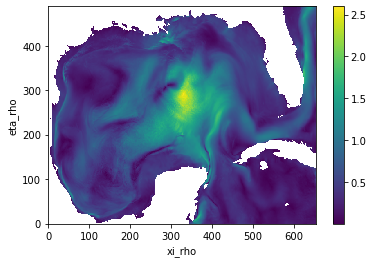

In [18]:
U = ds.u.isel(ocean_time=0,s_rho=-1)
V = ds.v.isel(ocean_time=0,s_rho=-1)

U_rho = grid.interp(U, "X", to="center", boundary="extend")
V_rho = grid.interp(V, "Y", to="center", boundary="extend")

speed = np.sqrt(U_rho ** 2 + V_rho ** 2)
speed.plot()

## What about the curvilinear grid?

<div>
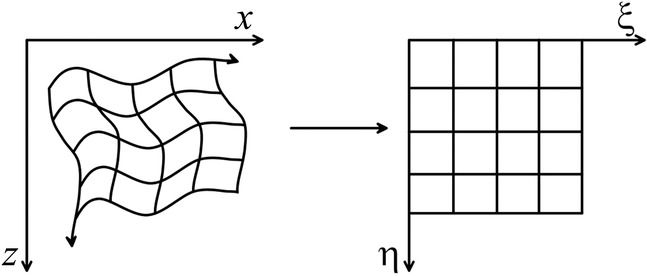
source:<a href="https://doi.org/10.1111/1365-2478.12844">https://doi.org/10.1111/1365-2478.12844</a>
</div>

</br></br></br>

#### Grid metrics

$$ \large \frac{\partial x}{\partial \xi} = dx = \frac{1}{pm}\ . $$
$$ \large\frac{\partial y}{\partial \eta} = dy = \frac{1}{pn}\ . $$

</br></br></br>
### Relative Vorticity

The relative vorticity is a fundamental quantity of interest in ocean circulation theory. It is defined as

$$ \large \zeta = - \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} \ . $$

$$ \large \zeta = - \frac{\partial u}{\partial \eta}\frac{\partial \eta}{\partial y} + \frac{\partial v}{\partial \xi}\frac{\partial \xi}{\partial x} \ . $$

On the c-grid, including the ROMS metrics, we get the expression: 

$$ \large \zeta =  (- \frac{\delta_j u}{pn} + \frac{\delta_i v}{pm} ) \ . $$

In xgcm, we calculate this quanity as

In [85]:
U = ds.u.isel(ocean_time=0,s_rho=-1)
V = ds.v.isel(ocean_time=0,s_rho=-1)

U_rho = grid.interp(U, axis="X",to="center", boundary="extend")  
dUdy = grid.diff(U, axis="Y", boundary="extend")
pn=grid.interp(grid.interp(ds.pn, "X"), "Y")
    
V_rho = grid.interp(V, axis="Y",to="center", boundary="extend")
dVdx = grid.diff(V, axis="X", boundary="extend")
pm=grid.interp(grid.interp(ds.pm, "X"), "Y")



<div>
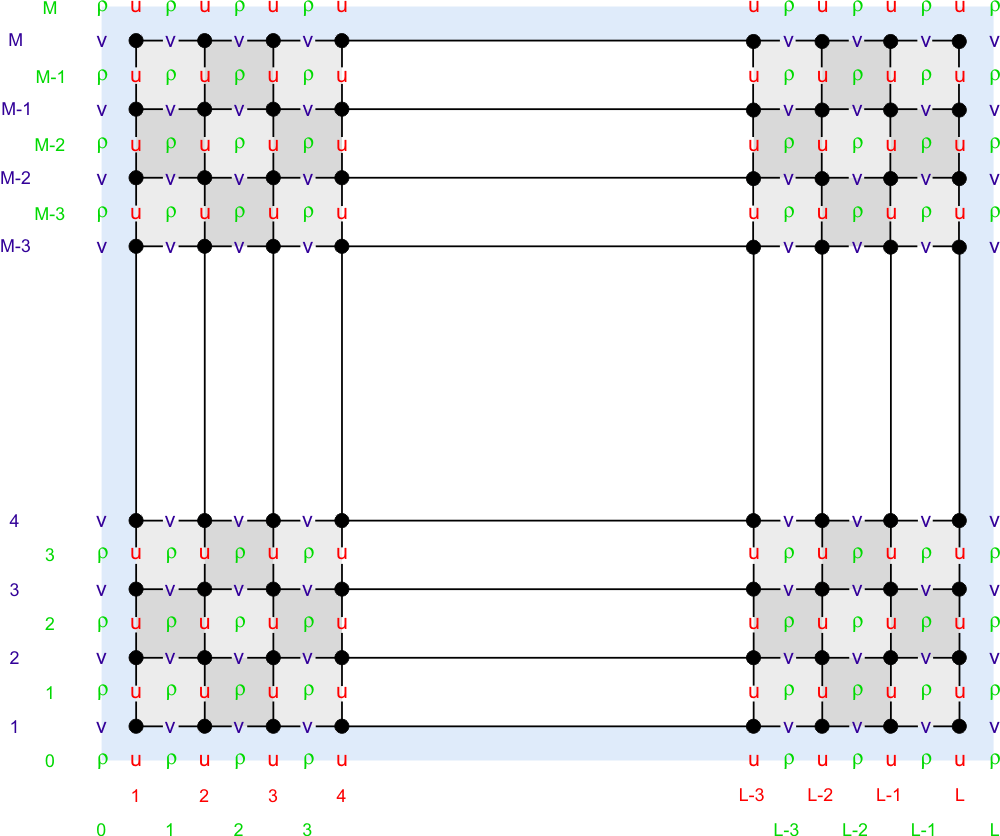
source:<a href="https://www.myroms.org/wiki/Numerical_Solution_Technique">myroms.org</a>
</div>


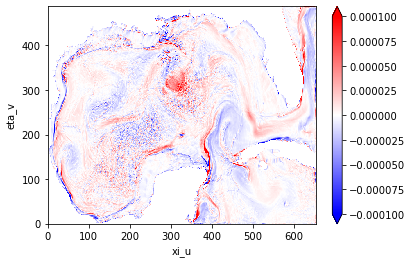

In [92]:
zeta = dVdx*pm - dUdy*pn
zeta.plot(vmin=-1e-4, vmax=1e-4,cmap='bwr')

## Exercise

### Calculate the divergence of velocity

The divergence of the horizontal flow is is expressed as

$$ \large \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} $$


Compute the divergence on the C-grid, using xgcm, and plot like previous example. 

In [7]:
U = ds.u.isel(ocean_time=0,s_rho=0)
V = ds.v.isel(ocean_time=0,s_rho=0)

-------------------------------
# Vertical interpolation


<div>

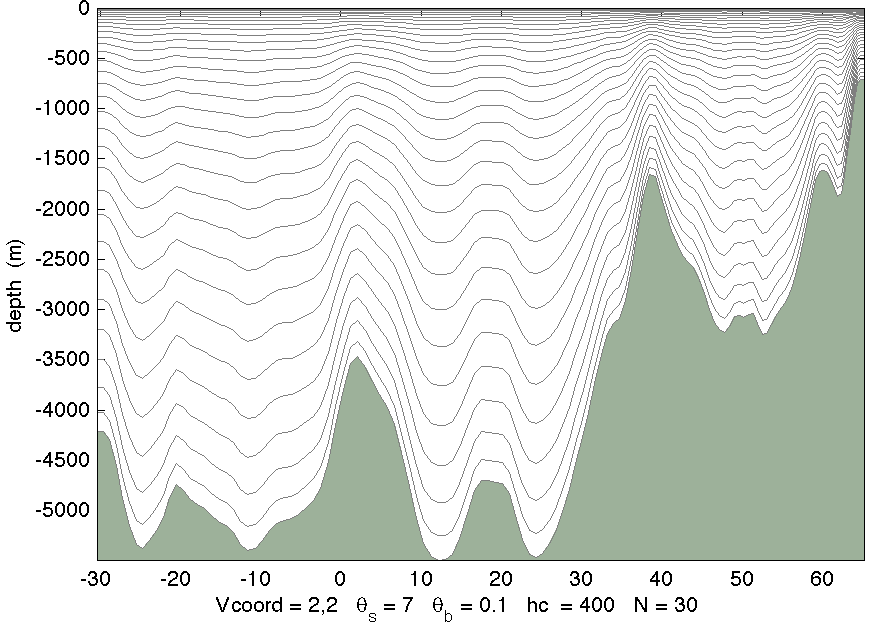
    <img src="images/roms_vertical.png" width="400">
source:<a href="https://www.myroms.org/wiki/Numerical_Solution_Technique">myroms.org</a>
</div>

In [55]:
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho

z_rho.attrs = {
            "long_name": "Depth at RHO-points",
            "time": "ocean_time",
            "field": "z_rho, scalar, series",
            "units": "m",
        }

ds.coords["z_rho"] = z_rho

Text(0.5, 1.0, 'Depth profile (z_rho vs s_rho)')

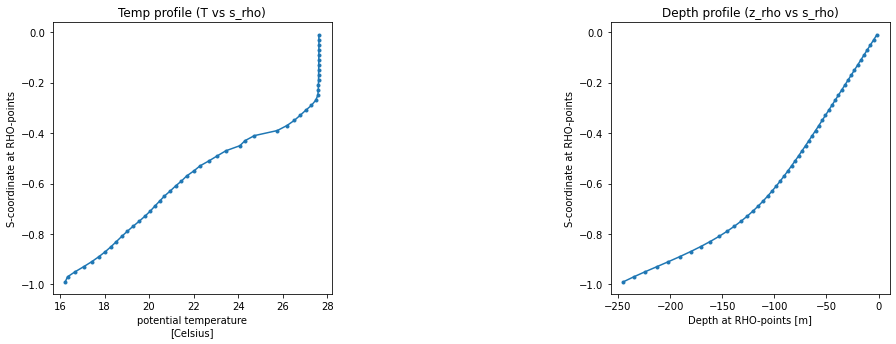

In [56]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[15,5])
fig.subplots_adjust(wspace=1.)


temp_s = ds.temp.isel(ocean_time=0,eta_rho=200,xi_rho=300)
temp_s.plot(ax=ax1, y='s_rho', yincrease=True, marker='.')


z_s = ds.z_rho.isel(ocean_time=0,eta_rho=200,xi_rho=300)
z_s.plot(ax=ax2, y='s_rho', yincrease=True, marker='.')


ax1.set_title('Temp profile (T vs s_rho)')
ax2.set_title('Depth profile (z_rho vs s_rho)')


In [64]:
import numpy as np
Z_target = np.linspace(0, -250, 30)

temp_transformed = grid.transform(ds.temp, 'Z', Z_target, target_data=ds.z_rho)

/scratch/training/python_geos/conda/envs/training/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


Text(0.5, 1.0, 'Interpolated Temp (T vs z_rho)')

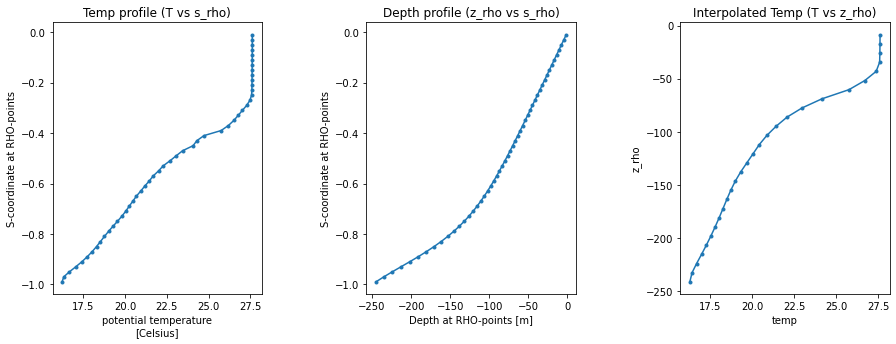

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[15,5])
fig.subplots_adjust(wspace=0.5)

temp_s.plot(ax=ax1, y='s_rho', yincrease=True, marker='.')
z_s.plot(ax=ax2, y='s_rho', yincrease=True, marker='.')
temp_transformed.isel(ocean_time=0,eta_rho=200,xi_rho=300).plot(ax=ax3,y='z_rho',yincrease=True, marker='.')


ax1.set_title('Temp profile (T vs s_rho)')
ax2.set_title('Depth profile (z_rho vs s_rho)')
ax3.set_title('Interpolated Temp (T vs z_rho)')




## Exercise

The depth profile of Salinity is shown below. Now try to plot Salinity as a profile of Temperature linearly interpolated between 16 and 28 C. 

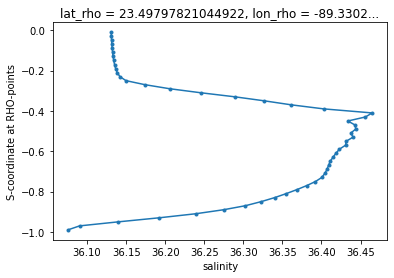

In [61]:
salt_s = ds.salt.isel(ocean_time=0,eta_rho=200,xi_rho=300)
salt_s.plot( y='s_rho', yincrease=True, marker='.')

In [ ]:
T_target = np.linspace(16, 28, 20)

salt_transformed = # Enter your expression here

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[15,5])
fig.subplots_adjust(wspace=0.5)


ds.salt.isel(ocean_time=0,eta_rho=200,xi_rho=300).plot(ax=ax1, y='s_rho', yincrease=True, marker='.')
ds.temp.isel(ocean_time=0,eta_rho=200,xi_rho=300).plot(ax=ax2, y='s_rho', yincrease=True, marker='.')
salt_transformed.isel(ocean_time=0,eta_rho=200,xi_rho=300).plot(ax=ax3, y='temp',yincrease=True, marker='.')

ax1.set_title('Salt profile (T vs s_rho)')
ax2.set_title('Temp profile (S vs s_rho)')
ax3.set_title('Interpolated Salt (S vs T)')

/scratch/training/python_geos/conda/envs/training/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


Text(0.5, 1.0, 'Interpolated Salt (S vs T)')

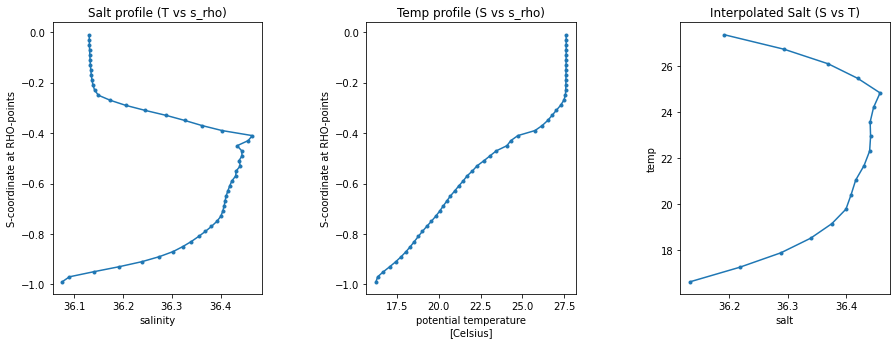

In [79]:
T_target = np.linspace(16, 28, 20)

salt_transformed = grid.transform(ds.salt, 'Z', T_target, target_data=ds.temp)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[15,5])
fig.subplots_adjust(wspace=0.5)


ds.salt.isel(ocean_time=0,eta_rho=200,xi_rho=300).plot(ax=ax1, y='s_rho', yincrease=True, marker='.')
ds.temp.isel(ocean_time=0,eta_rho=200,xi_rho=300).plot(ax=ax2, y='s_rho', yincrease=True, marker='.')
salt_transformed.isel(ocean_time=0,eta_rho=200,xi_rho=300).plot(ax=ax3, y='temp',yincrease=True, marker='.')

ax1.set_title('Salt profile (T vs s_rho)')
ax2.set_title('Temp profile (S vs s_rho)')
ax3.set_title('Interpolated Salt (S vs T)')